In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

In [3]:
import pandas as pd
import numpy as np

In [4]:
def read_data(init):
    """
    Reads and concatenates parquet files containing forecast and error data for GFS, NAM, and HRRR weather models
    for the years 2018 to 2021, with random forecasts that have a forecast hour of 0 removed.

    Args:
        init (str): A string representing the initial time of the forecast (in UTC).

    Returns:
        tuple of pandas.DataFrame: A tuple containing three dataframes, one for each weather model, with random
        forecasts that have a forecast hour of 0 removed.
    """
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    # create empty lists to hold dataframes for each model
    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    # concatenate dataframes for each model
    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # remove random forecasts that have forecast hours 0 for each model
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]

    # return dataframes for each model
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [5]:
gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    "12"
)

In [6]:
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
    hrrr_fcast_and_error_df["station"] == "SCHU"
]

In [7]:
hrrr_fcast_and_error_df

,station,valid_time,time,t2m_HRRR,d2m_HRRR,u_total_HRRR,u_dir_HRRR,latitude,longitude,new_tp_HRRR,...,mslma_error,t2m_nysm,d2m_nysm,u_total_nysm,u_dir_nysm,new_tp_nysm,mslma_nysm,lead_time_DAY,lead_time_HOUR,lead_time_ONLY_HOURS
46874,SCHU,2018-01-01 14:00:00,2018-01-01 12:00:00,-26.027145,-28.905670,0.644868,187.528809,43.110052,-73.591823,0.00,...,2.682983,-25.742041,-28.596741,1.591372,210.035599,0.000000,1025.776978,0,2,2.0
46875,SCHU,2018-01-01 15:00:00,2018-01-01 12:00:00,-21.798660,-25.074158,1.103367,155.350861,43.110052,-73.591823,0.00,...,3.851929,-21.868660,-26.147049,1.213672,157.646805,0.000000,1025.878052,0,3,3.0
46876,SCHU,2018-01-01 16:00:00,2018-01-01 12:00:00,-19.001190,-22.717117,0.666412,145.490784,43.110052,-73.591823,0.00,...,4.029907,-19.732401,-26.048782,1.831618,164.235596,0.000000,1025.290039,0,4,4.0
46877,SCHU,2018-01-01 17:00:00,2018-01-01 12:00:00,-17.341324,-21.778854,0.146325,117.390900,43.110052,-73.591823,0.00,...,3.784058,-17.451130,-25.813904,1.986071,153.697601,0.000000,1024.595947,0,5,5.0
46878,SCHU,2018-01-01 18:00:00,2018-01-01 12:00:00,-16.004486,-21.128281,0.255038,85.514633,43.110052,-73.591823,0.00,...,4.404968,-15.916540,-24.726959,1.331371,132.341202,0.000000,1023.705017,0,6,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211259,SCHU,2021-12-31 19:00:00,2021-12-31 12:00:00,6.392395,5.345856,1.782805,161.412079,43.110052,-73.591823,0.10,...,3.422058,3.899532,3.803131,0.315535,11.370697,0.049995,1008.107971,0,7,7.0
3211260,SCHU,2021-12-31 20:00:00,2021-12-31 12:00:00,6.195587,5.682465,1.739889,204.278564,43.110052,-73.591823,0.33,...,4.159973,3.722372,3.624664,0.685964,323.019989,0.000000,1007.940002,0,8,8.0
3211261,SCHU,2021-12-31 21:00:00,2021-12-31 12:00:00,6.043976,5.721527,0.724377,267.333710,43.110052,-73.591823,0.73,...,3.995972,3.513443,3.423706,2.181222,109.898590,0.400002,1007.973999,0,9,9.0
3211262,SCHU,2021-12-31 22:00:00,2021-12-31 12:00:00,5.600861,5.521606,1.026156,29.092915,43.110052,-73.591823,1.34,...,3.408997,3.225442,3.124664,1.200701,325.575409,0.470001,1008.491028,0,10,10.0


In [8]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout(
        {"font_size": 18, "xaxis_title_font_size": 24, "yaxis_title_font_size": 24}
    )
)

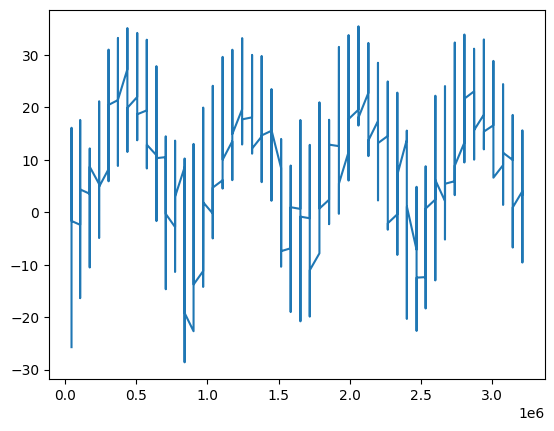

In [9]:
import matplotlib.pyplot as plt


plt.plot(hrrr_fcast_and_error_df["t2m_nysm"])

Isolate one NYSM station and drop unnecessary columns 

In [10]:
hrrr_fcast_and_error_df.keys()

Index(['station', 'valid_time', 'time', 't2m_HRRR', 'd2m_HRRR', 'u_total_HRRR',
       'u_dir_HRRR', 'latitude', 'longitude', 'new_tp_HRRR', 'mslma_HRRR',
       'orog', 't2m_error', 'd2m_error', 'u_total_error', 'u_dir_error',
       'new_tp_error', 'mslma_error', 't2m_nysm', 'd2m_nysm', 'u_total_nysm',
       'u_dir_nysm', 'new_tp_nysm', 'mslma_nysm', 'lead_time_DAY',
       'lead_time_HOUR', 'lead_time_ONLY_HOURS'],
      dtype='object')

In [11]:
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.drop(
    columns=[
        "station",
        "valid_time",
        "time",
        "lead_time_DAY",
        "lead_time_HOUR",
        "lead_time_ONLY_HOURS",
        "t2m_error",
        "d2m_error",
        "u_total_error",
        "u_dir_error",
        "new_tp_error",
        "mslma_error",
    ]
)

In [12]:
df = pd.read_parquet(
    "/home/aevans/ai2es/processed_data/HRRR/ny/HRRR_2018_01_direct_compare_to_nysm_sites_mask_water.parquet"
)

In [13]:
df

,,,level_0,index,latitude,longitude,t2m,sh2,d2m,r2,u10,v10,...,asnow,cape,dswrf,dlwrf,gh,u_total,u_dir,lead time,lsm,new_tp
valid_time,time,station,,,,,,,,,,,,,,,,,,,,,
2018-01-01 02:00:00,2018-01-01 00:00:00,ADDI,59218878,121128,42.045955,-77.218867,-18.711386,0.00070,-21.562979,76.699997,3.211771,-2.817635,...,0.000004,0.0,0.000000,148.600006,5221.354492,4.272533,311.259949,2,1.0,NaN
2018-01-01 03:00:00,2018-01-01 01:00:00,ADDI,59218879,326784,42.045955,-77.218867,-19.199194,0.00068,-21.993216,76.800003,3.321081,-2.272873,...,0.000007,0.0,0.000000,146.800003,5215.425781,4.024367,304.386841,2,1.0,0.001
2018-01-01 04:00:00,2018-01-01 02:00:00,ADDI,59218880,532440,42.045955,-77.218867,-19.118689,0.00068,-21.918570,76.500000,3.298830,-1.821096,...,0.000001,0.0,0.000000,147.100006,5210.410645,3.768112,298.900574,2,1.0,0.000
2018-01-01 05:00:00,2018-01-01 03:00:00,ADDI,59218881,738096,42.045955,-77.218867,-19.439062,0.00065,-22.570868,73.800003,2.992857,-0.877062,...,0.000000,0.0,0.000000,147.600006,5207.041992,3.118722,286.333313,2,1.0,0.000
2018-01-01 06:00:00,2018-01-01 04:00:00,ADDI,59218882,943752,42.045955,-77.218867,-19.760291,0.00063,-22.821158,74.400002,3.115693,-0.789671,...,0.000000,0.0,0.000000,146.899994,5201.477539,3.214206,284.222107,2,1.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-31 21:00:00,2018-01-31 19:00:00,YORK,62027200,99664375,40.929358,-73.141257,-1.529333,0.00178,-9.795081,53.700001,1.002357,2.208010,...,0.000000,0.0,145.800003,218.600006,5518.163574,2.424877,204.416351,2,1.0,0.000
2018-01-31 22:00:00,2018-01-31 20:00:00,YORK,62027201,99870031,40.929358,-73.141257,-2.546667,0.00201,-8.255286,63.700001,-0.275732,1.592169,...,0.000000,0.0,2.400000,222.000000,5530.888672,1.615868,170.174957,2,1.0,0.000
2018-01-31 23:00:00,2018-01-31 21:00:00,YORK,62027202,100075687,40.929358,-73.141257,-3.761206,0.00192,-8.839880,66.199997,0.268746,1.995142,...,0.000000,0.0,0.000000,224.600006,5538.740234,2.013161,187.671600,2,1.0,0.000


Create your target variable, and create a target variable column. The newly created target column won’t have values in the final 12 rows, so we’ll drop those

In [14]:
target_sensor = "t2m"
features = list(df.columns.difference([target_sensor]))

forecast_lead = 12
target = f"{target_sensor}_lead_{forecast_lead}"

df[target] = df[target_sensor].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

In [18]:
df

,valid_time,time,station,level_0,index,latitude,longitude,t2m,sh2,d2m,...,cape,dswrf,dlwrf,gh,u_total,u_dir,lead time,lsm,new_tp,t2m_lead_12
0,2018-01-01 02:00:00,2018-01-01 00:00:00,ADDI,59218878,121128,42.045955,-77.218867,-18.711386,0.00070,-21.562979,...,0.0,0.000000,148.600006,5221.354492,4.272533,311.259949,2,1.0,NaN,-17.277151
1,2018-01-01 03:00:00,2018-01-01 01:00:00,ADDI,59218879,326784,42.045955,-77.218867,-19.199194,0.00068,-21.993216,...,0.0,0.000000,146.800003,5215.425781,4.024367,304.386841,2,1.0,0.001,-16.224280
2,2018-01-01 04:00:00,2018-01-01 02:00:00,ADDI,59218880,532440,42.045955,-77.218867,-19.118689,0.00068,-21.918570,...,0.0,0.000000,147.100006,5210.410645,3.768112,298.900574,2,1.0,0.000,-13.675757
3,2018-01-01 05:00:00,2018-01-01 03:00:00,ADDI,59218881,738096,42.045955,-77.218867,-19.439062,0.00065,-22.570868,...,0.0,0.000000,147.600006,5207.041992,3.118722,286.333313,2,1.0,0.000,-13.287878
4,2018-01-01 06:00:00,2018-01-01 04:00:00,ADDI,59218882,943752,42.045955,-77.218867,-19.760291,0.00063,-22.821158,...,0.0,0.000000,146.899994,5201.477539,3.214206,284.222107,2,1.0,0.000,-12.706030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61597,2018-01-31 09:00:00,2018-01-31 07:00:00,YORK,62027188,97196503,40.929358,-73.141257,-5.868994,0.00148,-12.087378,...,0.0,0.000000,192.899994,5392.019531,3.795766,309.006378,2,1.0,0.000,-1.529333
61598,2018-01-31 10:00:00,2018-01-31 08:00:00,YORK,62027189,97402159,40.929358,-73.141257,-6.205420,0.00148,-12.071021,...,0.0,0.000000,191.500000,5422.973145,3.554612,305.569641,2,1.0,0.000,-2.546667
61599,2018-01-31 11:00:00,2018-01-31 09:00:00,YORK,62027190,97607815,40.929358,-73.141257,-6.414404,0.00136,-13.097937,...,0.0,0.000000,187.500000,5441.456055,3.861381,282.712219,2,1.0,0.000,-3.761206
61600,2018-01-31 12:00:00,2018-01-31 10:00:00,YORK,62027191,97813471,40.929358,-73.141257,-6.542273,0.00125,-14.085669,...,0.0,0.000000,186.399994,5453.331055,4.360332,278.123230,2,1.0,0.000,-3.673529


Create and hold out a test set

drop all cols with strings and unvaluable info like index
Always make sure it is sorted correctly by time and station
edit time of year with cos/sin "encode"
df['day_of_year'] = df['valid_time'].dt.dayofyear
?? subrtract a row in setting forecast hours ??



In [13]:
test_start = 19563

df_train = hrrr_fcast_and_error_df.iloc[:19563].copy()
df_test = hrrr_fcast_and_error_df.iloc[19563:].copy()

print("Test set fraction:", len(df_test) / len(hrrr_fcast_and_error_df))

Test set fraction: 0.2495108758200023


Standardize your features and target

In [14]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

create a PyTorch Dataset class, which is simpler than you might think. This strategy lets us lean on PyTorch’s nice DataLoader class to keep the model training and evaluation code super clean.

Our custom Dataset just needs to specify what happens when somebody requests the i’th element of the dataset. In a tabular dataset, this would be the i’th row of the table, but here we need to retrieve a sequence of rows.

So, given i and the sequence_length, we return the block of data from i - sequence_length through row i. If i is at the beginning of the dataset, we pad by repeating the first row as many times as needed to make the output have sequence_length rows. The only trick is avoiding off-by-1 errors in the slicing and padding.

All the magic happens in the __getitem__ method in this snippet.

In [15]:
import torch
from torch.utils.data import Dataset


class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start : (i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0 : (i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [16]:
# Let’s look at a small example to build intuition about how it works. Namely, let’s grab the 27’th entry in the dataset with a sequence length of 4.

i = 27
sequence_length = 4

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-1.4497e+00, -1.7762e+00, -5.4111e-04,  8.1898e-04,  8.1243e-01,
          7.0300e-01, -1.4117e-01, -1.6911e-01, -1.7071e-01, -1.4175e+00,
          1.4362e-02, -1.9943e-01,  4.9968e-01,  7.9216e-01],
        [-1.6018e+00, -1.8553e+00, -5.4111e-04,  8.1898e-04,  7.6328e-01,
          6.7636e-01, -1.4117e-01, -1.6911e-01, -1.7071e-01, -1.4504e+00,
          1.2149e-01,  4.2872e-01,  6.4749e-01, -8.6320e-01],
        [-1.6355e+00, -1.8701e+00, -5.4111e-04,  8.1898e-04,  7.6208e-01,
          6.9691e-01, -1.5332e-01, -1.6911e-01, -1.7071e-01, -1.4876e+00,
          1.4533e-01, -1.6451e+00,  1.1574e+00, -1.0197e+00],
        [-1.7131e+00, -1.9066e+00, -5.4111e-04,  8.1898e-04,  8.2801e-01,
          7.3967e-01, -1.5332e-01, -1.6911e-01, -1.7071e-01, -1.5212e+00,
          1.6765e-01, -1.0365e+00,  1.5842e+00, -1.1782e+00]])


The next step is to set the dataset in a PyTorch DataLoader, which will draw minibatches of data for us. Let’s try a small batch size of 3, to illustrate.

In [17]:
from torch.utils.data import DataLoader

torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 4, 14])
tensor([[[-3.3778e-01, -3.6806e-01, -5.4111e-04,  8.1898e-04,  8.1483e-01,
           8.6652e-01, -1.4846e-01, -1.6911e-01, -1.7071e-01, -5.4937e-01,
           2.3856e-02,  6.4612e-02, -1.3065e+00, -3.4168e-01],
         [-2.3539e-01, -3.7836e-01, -5.4111e-04,  8.1898e-04,  7.3810e-01,
           8.5266e-01, -1.5332e-01, -1.6911e-01, -1.7071e-01, -3.0239e-01,
          -3.2976e-01, -3.2410e-02, -8.9517e-01,  7.4691e-02],
         [-1.3541e-01, -3.7558e-01, -5.4111e-04,  8.1898e-04,  7.2852e-01,
           8.4024e-01, -1.5332e-01, -1.6911e-01, -1.7071e-01, -1.2657e-01,
          -2.9962e-01,  4.4794e-02,  1.3613e-01,  2.4120e-01],
         [-2.6292e-02, -3.4369e-01, -5.4111e-04,  8.1898e-04,  6.3860e-01,
           7.7132e-01, -1.5332e-01, -1.6911e-01, -1.7071e-01,  5.6822e-02,
          -3.7254e-01, -3.1139e-03,  9.8118e-01,  6.8673e-01]],

        [[-1.3320e+00, -1.3771e+00, -5.4111e-04,  8.1898e-04,  1.5377e+00,
           1.5871e+00, -1.5332e-01, -1.6911e-01,

with a sequence of 48 time steps. For training, we’ll shuffle the data (the rows within each data sequence are not shuffled, only the order in which we draw the blocks). For the test set, shuffling isn’t necessary.

In [18]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 12

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test, target=target, features=features, sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 12, 14])
Target shape: torch.Size([4])


Most importantly, we have to keep track of which dimension represents the batch in our input tensors. As we just saw, our data loaders use the first dimension for this, but the PyTorch LSTM layer’s default is to use the second dimension instead. So we set batch_first=True to make the dimensions line up, but confusingly, this doesn’t apply to the hidden and cell state tensors. In the forward method, we initialize h0 and c0 with batch size as the second dimension.

We’ll hard code a single layer just to keep things simple.

The output layer of the model is linear with a single output unit because we’re doing regression. This is one of only two lines of code that would need to change for a classification task.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UnfoldingLSTM(nn.ModuleList):
    def __init__(self):
        super(UnfoldingLSTM, self).__init__()

        # Number of samples per time step
        self.batch_size = 2

        # Dimension of weight vectors
        self.hidden_dim = 16

        # Dimension of embedded tensor
        self.embedding_dim = 2

        # The vocabulary size
        self.input_size = 4

        # Number of time steps
        self.sequence_len = 2

        # Initialize embedding layer
        self.embedding = nn.Embedding(self.input_size, self.embedding_dim)

        # Initialize LSTM Cell
        # Initialize LSTM Cell for the first layer
        self.lstm_cell_layer_1 = nn.LSTMCell(self.embedding_dim, self.hidden_dim)

        # Initialize LSTM Cell for the second layer
        self.lstm_cell_layer_2 = nn.LSTMCell(self.hidden_dim, self.hidden_dim)

    def forward(self, x):
        # batch_size x hidden_size
        hidden_state = torch.zeros(x.size(0), self.hidden_dim)
        cell_state = torch.zeros(x.size(0), self.hidden_dim)
        hidden_state_2 = torch.zeros(x.size(0), self.hidden_dim)
        cell_state_2 = torch.zeros(x.size(0), self.hidden_dim)

        # weights initialization
        torch.nn.init.xavier_normal_(hidden_state)
        torch.nn.init.xavier_normal_(cell_state)
        torch.nn.init.xavier_normal_(hidden_state_2)
        torch.nn.init.xavier_normal_(cell_state_2)

        # From idx to embedding
        out = self.embedding(x)

        # Prepare the shape for LSTMCell
        out = out.view(self.sequence_len, x.size(0), -1)

        # Unfolding LSTM
        # Last hidden_state will be used to feed the fully connected neural net
        for i in range(self.sequence_len):
            hidden_state, cell_state = self.lstm_cell_1(
                out[i], (hidden_state, cell_state)
            )
            hidden_state_2, cell_state_2 = self.lstm_cell_2(
                hidden_state, (hidden_state_2, cell_state_2)
            )

        # Last hidden state is passed through a fully connected neural net
        out = self.fully_connected(hidden_state_2)

        return out

In [20]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [21]:
learning_rate = 5e-5
num_hidden_units = 16

model = UnfoldingLSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [26]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = torch.tensor(X).to(torch.int64).long()
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

In [27]:
batch_size = 100
sequence_length = 12
learning_rate = 0.001
num_hidden_units = 14

experiment = Experiment(
    api_key="leAiWyR5Ck7tkdiHIT7n6QWNa",
    project_name="general",
    workspace="shmaronshmevans",
)
torch.manual_seed(101)

batch_size = batch_size
sequence_length = sequence_length

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test, target=target, features=features, sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

learning_rate = learning_rate
num_hidden_units = num_hidden_units

model = UnfoldingLSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopper = EarlyStopper(patience=5, min_delta=0)


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    val_loss = test_model(test_loader, model, loss_function)
    print()
    if early_stopper.early_stop(val_loss):
        break

# Report multiple hyperparameters using a dictionary:
hyper_params = {
    "learning_rate": learning_rate,
    "steps": sequence_length,
    "batch_size": batch_size,
}
experiment.log_parameters(hyper_params)

# Seamlessly log your Pytorch model
log_model(experiment, model, model_name="TheModel")
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/shmaronshmevans/general/bded43461d7c45669ef8631278e29daf
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (8.79 MB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     os packages                  : 1
COMET INFO:     source_code                  : 1
COMET I

Features shape: torch.Size([100, 12, 14])
Target shape: torch.Size([100])
Untrained test
--------


/tmp/tmp.HdfDagTB3m/ipykernel_1729502/4275946445.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).to(torch.int64).long()


IndexError: index out of range in self

## Evalutation

Evaluating the model is straightforward. First, let’s define a variant of the test function that actually returns the predictions. We also need a new DataLoader for the training set that isn’t shuffled, we can visualize the training and test set predictions chronologically. Lastly, it’s nice to un-standardize the predictions so they’re back in their original units.

In [ ]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"
plot_template = dict(
    layout=go.Layout(
        {"font_size": 18, "xaxis_title_font_size": 24, "yaxis_title_font_size": 24}
    )
)

fig = px.line(df_out, labels=dict(created_at="Date", value="T2M [Celsius]"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(
    xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False
)
fig.update_layout(
    template=plot_template, legend=dict(orientation="h", y=1.02, title_text="")
)
fig.show()